# *Saccharomyces cerevisiae* Genetic Interactions: Validation

**2015 August 14-15, 19, 21, 26, 28**

One validation strategy is to use a time-split approach. Find predictive seed gene sets using genetic interactions from a certain time period, and then validate those predictions using genetic interaction data determined after that time period. An important consideration is that YeastNet v2 uses data from BIOGRID downloaded June 2006. (What about YeastNet v1??) If using YeastNet v2, an approach could involve predicting on interactions from 2007-2009, and then validating on 2010-present (which would include the 2010 Costanzo SGA study). 

<s>It would be informative to identify the breakdown of the years of sources from BIOGRID (e.g. how many sources are of a given year).</s>

---

In [1]:
import itertools

In [1]:
import matplotlib

In [2]:
matplotlib.use('Agg')

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
import os

In [7]:
import re

---

Make 3 sets of genetic interactions: 1) pre-2007 2) 2007-2009 3) 2010-present. Check that they are mutually exclusive. 

In [4]:
def get_gene_pairs(interactionType, year1, year2):
    """
    Retrieve genetically interacting pairs from certain years
    INPUT:
        <int> years (inclusive) that source year should fall within
    OUTPUT:
        <set> genetically interacting pairs
    """
    genePairs = set()
    os.chdir('/work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.4.127.tab2')
    readFile = open('BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.4.127.tab2.txt')
    header = readFile.readline().rstrip().split('\t')
    authorCol = header.index('Author')
    interactionTypeCol = header.index('Experimental System')
    for line in readFile:
        tokens = line.rstrip().split('\t')
        if tokens[interactionTypeCol] == interactionType:
            author = tokens[authorCol]
            year = int(re.search(r'\((\d+)\)', author).group(1))
            if year >= year1 and year <= year2:
                if tokens[7] != tokens[8]:  # e.g. CDC15
                    genePairs.add(frozenset({tokens[7], tokens[8]}))
    readFile.close()
    return genePairs

In [5]:
pre2007 = get_gene_pairs('Dosage Rescue', 1900, 2006)
from2007to2009 = get_gene_pairs('Dosage Rescue', 2007, 2009)
after2009 = get_gene_pairs('Dosage Rescue', 2010, 2015)

In [29]:
list(pre2007 & from2007to2009)[:3]

[frozenset({'CDC42', 'CLA4'}),
 frozenset({'GLO3', 'SEC22'}),
 frozenset({'MEX67', 'MTR2'})]

So the gene sets aren't mutually exclusive, even for a given interaction type. Thus the genetic interaction sets will have to updated to ensure they are pairwise disjoint. For now, only the interactions from 2007-2009 will need to be written out to a file.

In [5]:
def write_disjoint_gene_sets(timeSet, interactionType):
    """
    INPUT: <string> type of genetic interaction
    """
    pre2007 = get_gene_pairs(interactionType, 1900, 2006)
    incl0709 = get_gene_pairs(interactionType, 2007, 2009)
    post2009 = get_gene_pairs(interactionType, 2010, 2015)
    pre2007 = pre2007 - (incl0709 | post2009)
    incl0709 = incl0709 - post2009
    str2var = {'pre2007': pre2007, 'incl0709': incl0709, 'post2009': post2009}
    os.chdir('/work/jyoung/genetic_interact/data/yeast_time_split')
    timeSetFile = open(timeSet + '-' + ''.join(interactionType.split()) + '.txt', 'w')
    for pair in str2var[timeSet]:
        timeSetFile.write('\t'.join(pair) + '\n')
    timeSetFile.close()

In [6]:
timeSplits = ('pre2007', 'incl0709', 'post2009')

In [7]:
interactionTypes = ('Dosage Rescue', 'Phenotypic Suppression', 'Negative Genetic', 
                    'Phenotypic Enhancement', 'Synthetic Lethality', 'Synthetic Growth Defect', 
                    'Positive Genetic', 'Synthetic Rescue', 'Dosage Lethality', 
                    'Dosage Growth Defect', 'Synthetic Haploinsufficiency')

In [8]:
for x in itertools.product(timeSplits, interactionTypes):
    write_disjoint_gene_sets(x[0], x[1])

**2015 August 24-28**

Add to the *func_net_pred.py* script code to output predicted interactors and assess performance. 

Regarding the validation of the predictions, a predicted interactor will be called positive if it shows up in the post-2009 set and not in the pre-2007 set. It will be called negative if it shows up in neither the pre-2007 nor the post-2009 sets. 

NOTE: <br>
BIOGRID interaction ID 644337 has CDC15 (YAR019C) interacting with itself. This causes problems when using storing genetically interacting pairs in *frozenset* as done in *get_gene_pairs( )* above. 

**2015 August 31**

STRATEGY: <br>
If a gene ranks higher in LLS than any known interactor of the seed, then the gene is itself is a predicted interactor.

Using the strategy above gives poor performance. All types of genetic interactions have AUCs between 0.5 and 0.6, with the exception of "Positive Genetic", which has an AUC of 0.84. 

**2015 September 4, 6**

The execution of the time-split validation strategy used thus far over the past week has been incorrect. First, if predicting a gene as an interactor if it ranks higher in LLS than any known interactor, then it most certainly is wrong to use true positive/negative calls on only these genes to construct a ROC curve. In that case, a perfect predictor would not give any negatives for the ROC construction. 

Second, the approach of computing from the 2007-2009 set a list of ranked LLS sums for all genes in the network is a correct start. However, making true positive/negative calls on this entire list is also not quite right, as it incorrectly penalizes true interactors from the 2007-2009 set by calling them negative. 

It is also important to realize that in making true positive/negative calls, the test space must be known. That is, if a predicted interactor is called negative, then the corresponding gene pair itself must have been experimentally tested and determined to not interact. 

On a related note, attention may need to be given to the Costanzo (2010) study, as here the test space should be known. However, the additional interactions released (2011-10-18 & 2012-05-18) might not be able to be used, as the YNL153C-YBL024W interaction in the 2011-10-18 release is not a query-array pair. Moreover, all of the gene pairs in the 2011-10-18 release have interaction scores greater than 0.08 in magnitude and p-values less than 0.05, so these are all actual interactions rather than a listing of tested gene pairs. 

**2015 September 7**

Consider using the Costanzo (2010) dataset as a gold standard to benchmark the predictions from the 2007-2009 time-split set. First, a couple of simple questions:

1. How many of the predictive seed genes (0.9 &le; AUC < 1.0) are in the Costanzo (2010) dataset?
2. How many of the genes in YeastNet v2 are in the Costanzo (2010) dataset?

Answers: <br>
1.) The raw data file from the Costanzo SOM has 4457 genes. Of all the <u>negative genetic</u> seed genes, there are 397 that are not in the Costanzo set!! Of the 64 predictive <u>negative genetic</u> seed genes (0.9 &le; AUC < 1.0), there are 29 that are not in the Costanzo set. <br>
2.) There are 2199 genes that are in YeastNet v2 but are NOT in the Costanzo dataset!! 

**2015 September 8**

In using the Costanzo (2010) dataset as a benchmark, the ROC curve for a seed gene is constructed as follows. Calculate the sum of LLS scores and sort it. March down this array; for a given score and the gene it corresponds to, it is assigned a 1 (true) if it is not in the 2007-2009 set and is an interactor of the seed according to Costanzo (2010). It is assigned a 0 (false) if it is not in the 2007-2009 set and was tested in Costanzo (2010), but is not an interactor. Alternatively, it is removed from consideration if it was not tested in Costanzo (2010) or was in the 2007-2009 set. 

It turns out that under this strategy of using SGA for validation, the performance is poor.

Number of genes in functional network: 5483


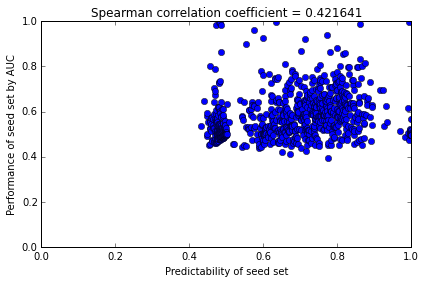

In [7]:
%run func_net_pred 'Negative Genetic'

Number of genes in functional network: 5483


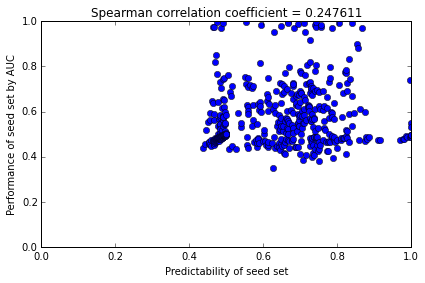

In [10]:
%run func_net_pred 'Positive Genetic'

**2015 September 17**

Instead of computing AUCs for each seed set as above, alternatively validate by combining all LLS scores into one vector and likewise with true positive/negative calls to produce a single ROC curve. Using the raw data from Costanzo (2010), performance is still poor (and slightly worse when using the lenient cutoff set):


Number of genes in functional network: 5483 

y_true_all and y_score_all are the same size.
Size of y_true_all: 2255925
Size of y_score_all: 2255925 



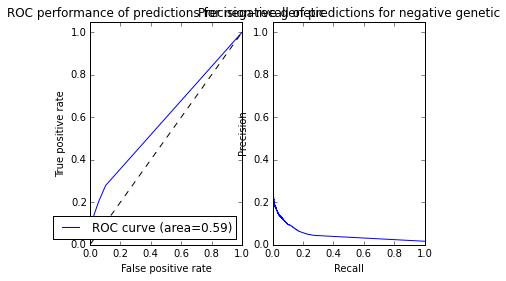

In [7]:
%run func_net_pred 'Negative Genetic'


Number of genes in functional network: 5483 

y_true_all and y_score_all are the same size.
Size of y_true_all: 2020948
Size of y_score_all: 2020948 



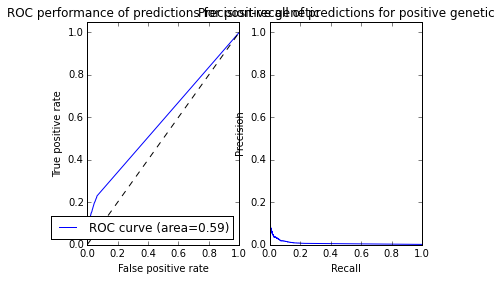

In [8]:
%run func_net_pred 'Positive Genetic'